In [236]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow import keras
from tensorflow.keras import callbacks
from uproot_io import Events, View

# Building a CNN for event classification.

We're only using **perfect reconstruction** (cheated files) for this.

1. Need to obtain the truth record for each event, 0 for CC_mu, 1 for CC_e and 2 for NC_x. 


In [237]:
# the data
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [337]:
event_numbers = np.array(list(set(events.event_number)))
event_numbers, len(event_numbers)

(array([   0,    1,    2, ..., 9262, 9263, 9264], dtype=int32), 9265)

# Labelling the events

In [239]:
def labelling():
    label = []
#     bad = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])
                
#         if 13 in mcp and 11 in mcp:
#             bad.append(n)
#             label.append(3)
        
        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

In [240]:
labels = labelling()

9310


((array([3512.,    0.,    0.,    0.,    0., 3715.,    0.,    0.,    0.,
         2083.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <BarContainer object of 10 artists>),
 None)

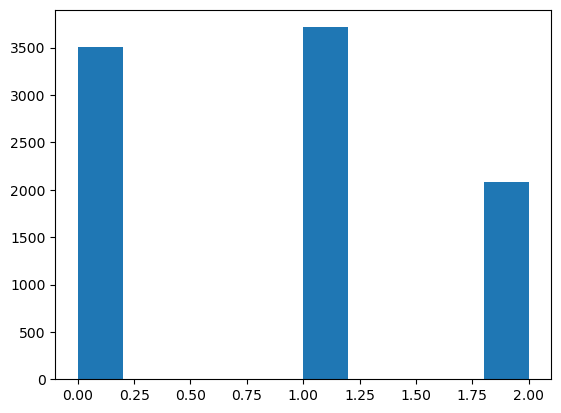

In [241]:
plt.hist(labels), print(len(labels))

In [242]:
def oneHotLabelling():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [243]:
one_hot_labels = oneHotLabelling()
one_hot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

# Making the images

In [336]:
view_w = View(events, "w")

In [245]:
def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

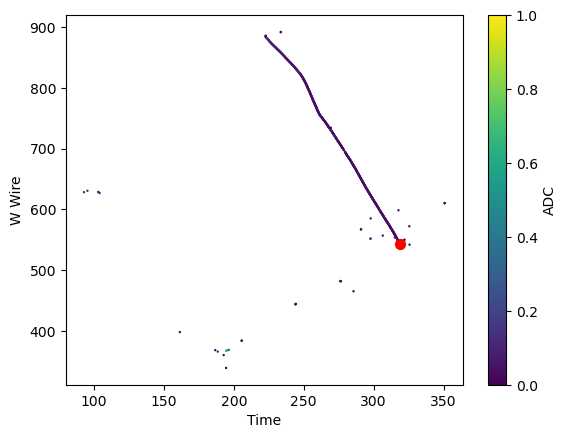

In [320]:
plot_w_event(2)

In [184]:
#image creation 1

def image():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]

        matrix_size = 128
        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)
        matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
        images.append(matrix)
        
#         matrix_size = 128
#         hit_matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)
#         hit_matrix = (hit_matrix > 0).astype(int)
#         hit_matrix = np.floor(hit_matrix).astype(np.uint8).reshape(128, 128, 1)
#         images.append(hit_matrix)
        

#         # Display the pixelated image
#         plt.imshow(hit_matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
#         plt.colorbar()
#         plt.title('Pixelated Image of Energy')
#         plt.show()
    
    return np.stack(images)

This improved version uses 256 pixels, and crops the picture by centering at the mean of x and z, and allowing 150 bins above and below this mean.

In [247]:
#image creation 2

def imagenew():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        vx = view_w.true_vtx_x[n]
        vz = view_w.true_vtx_z[n]

        matrix_size = 256
        #if vz >

        #range=[[np.floor(np.mean(x))-250, np.floor(np.mean(x))+250], [vz-250, vz+250]]

        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[np.floor(np.mean(x))-150, np.floor(np.mean(x))+150], [np.floor(np.mean(z))-150, np.floor(np.mean(z))+150]], weights=adc)
        matrix = (matrix > 0).astype(int)

        matrix = np.floor(matrix).astype(np.uint8).reshape(256, 256, 1)
        images.append(matrix)


    # Display the pixelated image
    #plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
    #plt.colorbar()
    #plt.title('Pixelated Image of Energy')
    #plt.show()
    
    return np.stack(images)

In [248]:
images = imagenew()

In [340]:
random_numbersold = np.random.randint(0,max(event_numbers) , max(event_numbers))
seventy = int(0.7*len(random_numbersold))
training = random_numbersold[:seventy]
testing = random_numbersold[seventy:]

In [249]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [250]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [251]:
len(training), len(testing)

(6445, 2763)

In [252]:
num_classes = 3

# The CNN

In [282]:
# model 1

input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
# x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 flatten_17 (Flatten)        (None, 516128)            0         
                                                                 
 dense_29 (Dense)            (None, 3)                 1548387   
                                                          

In [296]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 15
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [297]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [298]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


Epoch 1/15
51/51 [==============================] - 92s 2s/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.9857 - val_accuracy: 0.8317
Epoch 2/15
51/51 [==============================] - 78s 2s/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 1.0621 - val_accuracy: 0.8364
Epoch 3/15
51/51 [==============================] - 71s 1s/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 1.0519 - val_accuracy: 0.8306
Epoch 4/15
51/51 [==============================] - 91s 2s/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 1.0991 - val_accuracy: 0.8313
Epoch 5/15
51/51 [==============================] - 100s 2s/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 1.1435 - val_accuracy: 0.8292
Epoch 6/15
51/51 [==============================] - 97s 2s/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 1.1555 - val_accuracy: 0.8230
Epoch 7/15
51/51 [==============================] - 87s 2s/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 1.2319 - val_accuracy: 0.8270
Epoch 8/15
51/51 [=

KeyboardInterrupt: 

In [295]:
# cnn_model.save('modelv1')
cnn_model = model.load('modelv1')

INFO:tensorflow:Assets written to: modelv1/assets


INFO:tensorflow:Assets written to: modelv1/assets


In [299]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 5s 225ms/step
Number of images that were incorrectly classified = 473


In [300]:
accuracy = (2761-473)/2761
accuracy

0.8286852589641435

In [266]:
# model 2

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape
input_shape = x_train[0].shape  # Replace with the shape of your input data

# Input layer
input_layer = keras.layers.Input(x_train[0].shape)
# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output of the conv layers
x = Flatten()(x)

# Dense layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)  # 3 classes for the output

# Creating the model
model = keras.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 128)       738

In [328]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for - model 2, 20 is best
epochs = 15
# The learning rate (step size in gradient descent)
learning_rate = 0.0001

In [329]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [330]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)

Epoch 1/15
51/51 [==============================] - 463s 9s/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 1.4792 - val_accuracy: 0.8628
Epoch 2/15
51/51 [==============================] - 434s 9s/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 1.5167 - val_accuracy: 0.8588
Epoch 3/15
51/51 [==============================] - 568s 11s/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 1.6065 - val_accuracy: 0.8585
Epoch 4/15
51/51 [==============================] - 411s 8s/step - loss: 0.0070 - accuracy: 0.9971 - val_loss: 1.5521 - val_accuracy: 0.8617
Epoch 5/15
22/51 [===========>..................] - ETA: 4:31 - loss: 0.0060 - accuracy: 0.9975

KeyboardInterrupt: 

In [316]:
model.save('modelv2')
# model = model.load('modelv2')

INFO:tensorflow:Assets written to: modelv2/assets


INFO:tensorflow:Assets written to: modelv2/assets


In [332]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 40s 2s/step
Number of images that were incorrectly classified = 384


In [334]:
accuracy = (2761-384)/2761
accuracy

0.8609199565374864

Incorrect classification for image 35 : predicted = 2 with true = 0


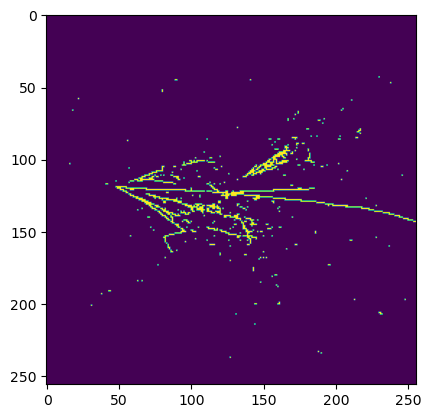

In [277]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 3
image_to_plot = x_test[incorrect_indices[im][0]]
fig, ax = plt.subplots(1, 1)
print('Incorrect classification for image',incorrect_indices[im][0],
      ': predicted =',incorrect_indices[im][1],
      'with true =',incorrect_indices[im][2])
ax.imshow(image_to_plot)

In [321]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [322]:
conf_matrix_decimals

array([[0.91089109, 0.05841584, 0.03069307],
       [0.03082502, 0.92475068, 0.0444243 ],
       [0.09076923, 0.22615385, 0.68307692]])

Text(50.722222222222214, 0.5, 'True Label')

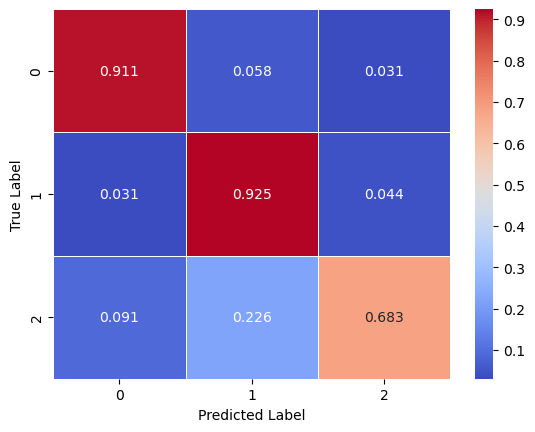

In [323]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Pandora

In [41]:
def image():
    
    images = []
    
    for n in event_numbers:

        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        
        if len(x) > 0:
            
            matrix_size = 128
            matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)

            matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
            images.append(matrix)
        
        else:
            print(n)


    #         # Display the pixelated image
    #         plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
    #         plt.colorbar()
    #         plt.title('Pixelated Image of Energy')
    #         plt.show()
    
    return np.stack(images)

In [42]:
images = image()

2517
4841
5873
6319
7344
7635
7721
8899


In [55]:
random_numbersold = np.random.randint(0,9201 , 9201)
seventy = int(0.7*len(random_numbersold))
training = random_numbersold[:seventy]
testing = random_numbersold[seventy:]
# np.save("training_events", training)
# np.save("testing_events", testing)


# training = np.load("training_events.npy")
# testing = np.load("testing_events.npy")

In [56]:
len(training)+len(testing)

9201

In [68]:
len(testing)

2761

In [57]:
len(images)

9201

In [58]:
remove = [2517, 2841, 5873, 6319, 7344, 7635, 7721, 8899]
training = [x for x in training if x not in remove]
testing = [x for x in testing if x not in remove]

SyntaxError: unexpected EOF while parsing (1285137494.py, line 3)

In [59]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [342]:
def oneHotLabelling2():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(more.event_number == n)[0]

        for i in index:
            parent = more.reco_parent_index[i]
            if parent == 0:
                mcp.append(more.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [344]:
y_test = oneHotLabelling2()

In [348]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = moreData.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = moreData[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

73/73 [==============================] - 32s 430ms/step
Number of images that were incorrectly classified = 3291


In [346]:
moreData.shape[0]

9265

In [347]:
accuracy = (9265-2844)/9265
accuracy

0.6930383162439288